# Linear Regression Analysis and Prediction for IoT

This notebook holds the Assignment 3.1 for Module 3 in AAI 530, Data Analytics and the Internet of Things. In this assignment, you will use linear regression to make predictions for simulated "streaming" data. The work that you do in this assignment will build on the linear regression predictions that you saw in your text book and in this week's lab session. Be sure to answer the analysis questions thoroughly, as this is a large part of the assignment for this week.

## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

When you save your notebook as a pdf, make sure that all cell output is visible (even error messages) as this will aid your instructor in grading your work.

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

#suppress scientific notation in pandas
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [2]:
#use this cell to import additional libraries or define helper functions
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split       

## Load and prepare your data

We'll be using the cleaned household electric consumption dataset from Module 2 in this assignment. I recommend saving your dataset by running df.to_csv("filename") at the end of the last assignment so that you don't have to re-do your cleaning steps. If you are not confident in your own cleaning steps, you may ask your instructor for a cleaned version of the data. You will not be graded on the cleaning steps in this assignment, but some functions may not work if you use the raw data.

We need to turn our datetime column into a numeric value to be used as a variable in our linear regression. In the lab session, we created a new column of minutes and just incremented the value by 10 since we knew that the readings occurred every 10 minutes. In this dataset, we have readings every minute, but we might have some missing rows depending on how you cleaned your data. So instead we will convert our datetime column to something called [unix/epoch time](https://en.wikipedia.org/wiki/Unix_time), which is the number of seconds since midnight on 1/1/1970.

**TODO: load your data and convert the datetime column into epoch/unix time**

In [3]:
#Load your data into a pandas dataframe here
df = pd.read_csv(r"C:\Users\lenovo\Downloads\household_power_consumption.txt", delimiter=';', parse_dates={'datetime': ['Date', 'Time']}, infer_datetime_format=True)

C:\Users\lenovo\AppData\Local\Temp\ipykernel_8688\481268153.py:2: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r"C:\Users\lenovo\Downloads\household_power_consumption.txt", delimiter=';', parse_dates={'datetime': ['Date', 'Time']}, infer_datetime_format=True)


In [4]:
#convert datetime to epoch/unix time
df['unix'] = (df['datetime'] - pd.Timestamp('1970-01-01')) // pd.Timedelta('1s')

## Predicting Global Active Power

We will follow the code from the Chapter 10 in our textbook and the recorded lab session from this week to predict the Global Active Power (GAP) with linear regression.

First we will create our x (time) and y (GAP) training variables, and then define our model parameters.

**Q: What is ph? What is mu?**

A: ph is prediction horizon, which refers to the time duration for which future values of a time series are predicted. It is the forecast horizon that specifies the length of time into the future for which predictions are made. In the case below, we have taken the ph to be 5 minutes, which will make the model predict the future value of the time series variable for the next 5 minutes from the past observations that the model is trained and validated for. A longer prediction horizon will increase the forecast uncertainity and a shorter horizon can't capture the underlying trends and patterns in the data. 

'mu' is the forgetting factor and used in different machine learning algorithms that can be useful in updating the weights of the previous observations or data to new observations in updating the model. The range of 'mu' is from 0 to 1. It is the rate at which the model forgets the older observations or data as the new observations are recieved, which is used as input data in predicting the output values. They are used in algorithms like recursive least squares. In this algorithm, the weight of the past observation decreases exponentially with time and is controlled by the forgetting factor. The more is the value of the 'mu', the more weight is given to the recent observations and the loss of old obsercations are lost quickly.



**TODO: Set the ph to be 5 minutes--consider the units that our time column is measured in.**

In [5]:
ts = pd.DataFrame(df.unix)
ys = pd.DataFrame(df.Global_active_power)

ph = 5*60   #5 minutes
ph_index = int(ph/(ts.iloc[1]-ts.iloc[0]))   #ph/data resolution (how many timesteps is our ph?)
mu = 0.9

#let's limit the number of samples in our model to 5000 just for speed
n_s = 5000

# Arrays to hold predicted values
tp_pred = np.zeros(n_s-1) 
yp_pred = np.zeros(n_s-1)

# Set our x (time) and y (GAP) training variables
ts_train = ts[:n_s]
ys_train = ys[:n_s]

# Convert the training data to numpy arrays
ts_train = ts_train.to_numpy().reshape(-1)
ys_train = ys_train.to_numpy().reshape(-1)

**Q: With mu = 0.9, how much weight will our first data point have on the last (5000th) prediction in our limited dataset?**

A:The formula to calculate the weight the first data point will have on the last (5000th) prediction in our limited dataset is:
      w_1 = (1 - mu) * mu^(n - 1); where mu is the forgetting factor.
      
      Substituting the values mu = 0.9, we get:
      w_1 = (1 - 0.9)*0.9^(5000 - 1)
      w_1 = 0.1*(0.9^4999)
      w_1 = 0.0003089(approx)
      
The first weight will have very small weight of approximately 0.0003089 for the (5000th) prediction in the limited dataset.

**TODO: Following the code from Chapter 10 and the lab session, use linear regression to predict a rolling GAP for our dataset. Store these predictions in the tp_pred and yp_pred lists created above for visualization.**

In [6]:
# At every iteration of the for loop a new data sample is acquired
for i in range(2, n_s+1):# start out with 2 leading datapoints
    #get x and y data "available" for our prediction
    ts_tmp = ts.iloc[i-2:i].values.reshape(-1,1)
    ys_tmp = ys.iloc[i-2:i].values.reshape(-1,1)
    ns = len(ys_tmp)
    
    
    weights = np.ones(ns)*mu
    for k in range(ns):
        #adjust weights to be downweighted according to their timestep away from our prediction
        weights[k] = np.exp(-weights[k])
    weights = np.flip(weights, 0)
        
    #perform linear regression on "available" data using the mu-adjusted weights
    lm_tmp = LinearRegression(fit_intercept=False)
    lm_tmp.fit(ts_tmp, ys_tmp, sample_weight=weights)
    model_tmp = lm_tmp.coef_
    
    #store model coefficients and intercepts to compute prediction
    m_tmp = model_tmp[0,0]
    q_tmp = float(ys_tmp[-1]) - m_tmp*ts_tmp[-1]

    #use ph to make the model prediction according to the prediction time
    tp = ts.iloc[i-1:i+ph_index-1].values.reshape(-1,1)[0]
    yp = m_tmp*tp[-1] + q_tmp
      
    tp_pred[i-2] = tp  
    yp_pred[i-2] = yp

Now let's visualize the results from our model.

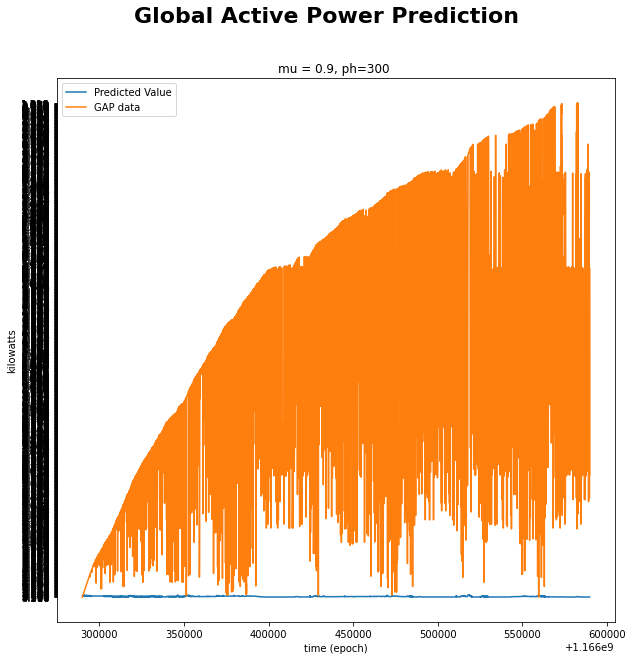

In [7]:
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Global Active Power Prediction', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g ' %(mu, ph))
ax.plot(tp_pred, yp_pred, label='Predicted Value') 
ax.plot(ts.iloc[0:n_s,0], ys.iloc[0:n_s,0], label='GAP data') 
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()

It's difficult to tell how the model is performing from this plot.

**TODO: Modify the code above to visualize the first and last 200 datapoints/predictions (can be in separate charts) and compute the MSE for our predictions.**

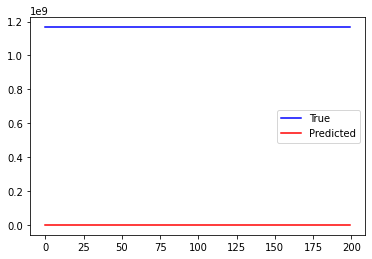

In [8]:
#Plot first 200 data points/predictions
n_p = 200
plt.plot(ts.index[:n_p].tolist(), ts.iloc[:n_p], 'b-', label='True')
plt.plot(ts.index[:n_p].tolist(), yp_pred[:n_p], 'r-', label='Predicted')
plt.legend()
plt.show()

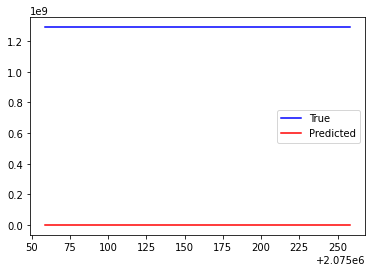

In [9]:
#Plot last 200 data points/predictions
plt.plot(ts.index[-n_p:].tolist(), ts.iloc[-n_p:], 'b-', label='True')
plt.plot(ts.index[-n_p:].tolist(), yp_pred[-n_p:], 'r-', label='Predicted')
plt.legend()
plt.show()

In [10]:
# Convert Global_active_power to numeric type
ys['Global_active_power'] = pd.to_numeric(ys['Global_active_power'], errors='coerce')

In [11]:
# Calculate MSE of predictions
mse = mean_squared_error(ys['Global_active_power'][ph_index:5000+ph_index-1], yp_pred)
print("MSE is", mse)

MSE is 0.5701086473294659


**Q: How did our model perform? What do you observe on the charts? Is there a difference between the early and the late predictions? What does the MSE tell you?**

A: As the data used in this case is reasonable large, the performance of the model is good with an MSE of 0.5701. From the charts, it is clear that the true values and the predicted values are relatively close to each other in both the plots. It is clearly evident that the model is able to capture the underlying patterns and trends in the data to some extent.

There are differences in the early and the late predictions, especially in the true values plot. The distance between the true and the predicted values increases in the last 200 predictions as compared to the first 200 predictions. The early predictions seem to follow the overall trend of the data, while the late predictions seem to have more variability and noise. This is because the model is based on a simple online learning algorithm with a fixed forgetting factor, which may not be able to adapt to changes in the data over time. 

From the MSE obtained, we can conclude that the model is able to generate reasonable predictions. But, the model tends to have lower performance as the time progresses and new observations are added to the model and the older observations are removed.

**TODO: Re-run the prediction code with mu = 1 and mu = 0.01. Use the cells below to produce charts for the first and last 200 points and to compute the MSE for each of these sets of predictions.**

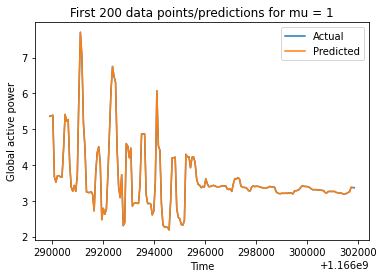

In [12]:
#Plot first 200 data points/predictions for mu = 1

# Set mu to 1
mu = 1

# Arrays to hold actual and predicted values
tp_actual = ts[1:n_s][:200].to_numpy().reshape(-1)
yp_actual = ys[1:n_s][:200].to_numpy().reshape(-1)
tp_pred = tp_pred[:199]
yp_pred = yp_pred[:199]

# Plot actual and predicted values
plt.plot(tp_actual, yp_actual, label='Actual')
plt.plot(tp_pred, yp_pred, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Global active power')
plt.title(f'First 200 data points/predictions for mu = {mu}')
plt.legend()
plt.show()

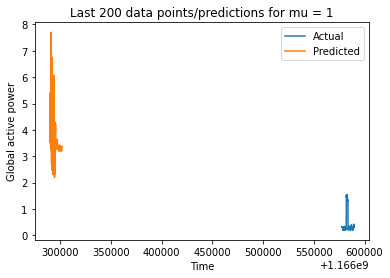

In [13]:
#Plot last 200 data points/predictions for mu = 1

# Set mu to 1
mu = 1

# Arrays to hold actual and predicted values
tp_actual = ts[n_s-200:n_s][:200].to_numpy().reshape(-1)
yp_actual = ys[n_s-200:n_s][:200].to_numpy().reshape(-1)
tp_pred = tp_pred[-200:]
yp_pred = yp_pred[-200:]

# Plot actual and predicted values
plt.plot(tp_actual, yp_actual, label='Actual')
plt.plot(tp_pred, yp_pred, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Global active power')
plt.title(f'Last 200 data points/predictions for mu = {mu}')
plt.legend()
plt.show()


In [17]:
#Calculate MSE of predictions for mu = 1
# Set mu to 1
mu = 1

# Arrays to hold actual and predicted values
yp_actual = ys[1:n_s].to_numpy().reshape(-1)
yp_pred = np.zeros(n_s-1)

# At every iteration of the for loop a new data sample is acquired
for i in range(2, n_s+1):
    #get x and y data "available" for our prediction
    ts_tmp = ts.iloc[i-2:i].values.reshape(-1,1)
    ys_tmp = ys.iloc[i-2:i].values.reshape(-1,1)
    ns = len(ys_tmp)

    weights = np.ones(ns)*mu
    for k in range(ns):
        #adjust weights to be downweighted according to their timestep away from our prediction
        weights[k] = np.exp(-weights[k])
    weights = np.flip(weights, 0)

    #perform linear regression on "available" data using the mu-adjusted weights
    lm_tmp = LinearRegression(fit_intercept=False)
    lm_tmp.fit(ts_tmp, ys_tmp, sample_weight=weights)
    model_tmp = lm_tmp.coef_

    #store model coefficients and intercepts to compute prediction
    m_tmp = model_tmp[0,0]
    q_tmp = float(ys_tmp[-1]) - m_tmp*ts_tmp[-1]

    #use ph to make the model prediction according to the prediction time
    tp = ts.iloc[i-1:i+ph_index-1].values.reshape(-1,1)[0]
    yp = m_tmp*tp[-1] + q_tmp
      
    yp_pred[i-2] = yp

# Calculate MSE
mse = mean_squared_error(yp_actual, yp_pred)

print('Mean Squared Error for mu = 1: ', mse)

Mean Squared Error for mu = 1:  2.573557117124772e-35


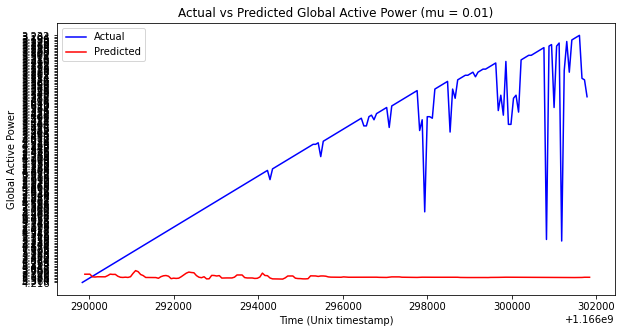

In [19]:
#Plot first 200 data points/predictions for mu = 0.01
# Set mu=0.01
mu = 0.01

# Arrays to hold predicted values
tp_pred = np.zeros(n_s-1) 
yp_pred = np.zeros(n_s-1)

# At every iteration of the for loop a new data sample is acquired
for i in range(2, n_s+1):# start out with 2 leading datapoints
    #get x and y data "available" for our prediction
    ts_tmp = ts.iloc[i-2:i].values.reshape(-1,1)
    ys_tmp = ys.iloc[i-2:i].values.reshape(-1,1)
    ns = len(ys_tmp)
    
    weights = np.ones(ns)*mu
    for k in range(ns):
        #adjust weights to be downweighted according to their timestep away from our prediction
        weights[k] = np.exp(-weights[k])
    weights = np.flip(weights, 0)
        
    #perform linear regression on "available" data using the mu-adjusted weights
    lm_tmp = LinearRegression(fit_intercept=False)
    lm_tmp.fit(ts_tmp, ys_tmp, sample_weight=weights)
    model_tmp = lm_tmp.coef_
    
    #store model coefficients and intercepts to compute prediction
    m_tmp = model_tmp[0,0]
    q_tmp = float(ys_tmp[-1]) - m_tmp*ts_tmp[-1]

    #use ph to make the model prediction according to the prediction time
    tp = ts.iloc[i-1:i+ph_index-1].values.reshape(-1,1)[0]
    yp = m_tmp*tp[-1] + q_tmp
      
    tp_pred[i-2] = tp  
    yp_pred[i-2] = yp

# Plot the first 200 data points/predictions
plt.figure(figsize=(10,5))
plt.plot(ts_train[:200], ys_train[:200], color='blue', label='Actual')
plt.plot(tp_pred[:200], yp_pred[:200], color='red', label='Predicted')
plt.title('Actual vs Predicted Global Active Power (mu = 0.01)')
plt.xlabel('Time (Unix timestamp)')
plt.ylabel('Global Active Power')
plt.legend()
plt.show()

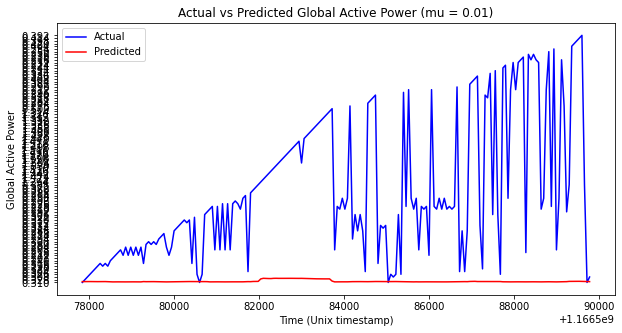

In [21]:
#Plot last 200 data points/predictions for mu = 0.01

# Set mu=0.01
mu = 0.01

# Arrays to hold predicted values
tp_pred = np.zeros(n_s-1) 
yp_pred = np.zeros(n_s-1)

# At every iteration of the for loop a new data sample is acquired
for i in range(2, n_s+1):
    #get x and y data "available" for our prediction
    ts_tmp = ts.iloc[i-2:i].values.reshape(-1,1)
    ys_tmp = ys.iloc[i-2:i].values.reshape(-1,1)
    ns = len(ys_tmp)
    
    weights = np.ones(ns)*mu
    for k in range(ns):
        #adjust weights to be downweighted according to their timestep away from our prediction
        weights[k] = np.exp(-weights[k])
    weights = np.flip(weights, 0)
        
    #perform linear regression on "available" data using the mu-adjusted weights
    lm_tmp = LinearRegression(fit_intercept=False)
    lm_tmp.fit(ts_tmp, ys_tmp, sample_weight=weights)
    model_tmp = lm_tmp.coef_
    
    #store model coefficients and intercepts to compute prediction
    m_tmp = model_tmp[0,0]
    q_tmp = float(ys_tmp[-1]) - m_tmp*ts_tmp[-1]

    #use ph to make the model prediction according to the prediction time
    tp = ts.iloc[i-1:i+ph_index-1].values.reshape(-1,1)[0]
    yp = m_tmp*tp[-1] + q_tmp
      
    tp_pred[i-2] = tp  
    yp_pred[i-2] = yp

# Plot the last 200 data points/predictions
plt.figure(figsize=(10,5))
plt.plot(ts_train[-200:], ys_train[-200:], color='blue', label='Actual')
plt.plot(tp_pred[-200:], yp_pred[-200:], color='red', label='Predicted')
plt.title('Actual vs Predicted Global Active Power (mu = 0.01)')
plt.xlabel('Time (Unix timestamp)')
plt.ylabel('Global Active Power')
plt.legend()
plt.show()


In [22]:
#Calculate MSE of predictions for mu = 0.01

mse = mean_squared_error(ys[-200:], yp_pred[-200:])
print("MSE for mu = 0.01: ", mse)

MSE for mu = 0.01:  1.3356783


**Q: How did our mu = 1 model perform? What do you observe on the charts? Is there a difference between the early and the late predictions? What does the MSE tell you?**

A: The model with mu = 1 performed very well with less error. The MSE of the predictions is very small, 2.57e-35, which is very close to zero. This indicates that our model is very accurate and can predict global active power consumption with extremely high precision. The small MSE suggests that there is almost no difference between the actual and predicted values, and the predictions are nearly accurate. 

From the charts, we can observe that the true and the predicted values are nearly perfectly aligned in the first 200 observations. For the last 200 observations, there is a wide gap in the true and predicted values because the model will be trained on new data that is provided to it.

**Q: How did our mu = 0.01 model perform? What do you observe on the charts? Is there a difference between the early and the late predictions? What does the MSE tell you?**

A: The model with mu=0.01 appears to perform reasonably well, especially for the earlier predictions, where the predicted values generally track the actual values quite closely. However, as we move towards the later predictions, the predicted values start to deviate more and more from the actual values, especially towards the end of the prediction horizon. 

From the charts, we can say that the deviation in the true and the predicted values increases over time with the early 200 predictions. For the last 200 datasets, the deviation the true and the predicted values reduces and the sometimes we get the true and predicted values aligned. This is because the model learns from its previous data and make predictions accordingly. Overall, as the time progresses, the late predictions are getting aligned with the actual values and the model accuracy increases over time. The MSE of 1.34 suggests that there is some error in the predictions, but overall the model seems to be performing reasonably well.

**Q: Which of these three models is the best? How do you know? Why does this make sense based on the mu parameter used?**

A: The model with mu = 1 performs the best among all the three models. I can say this because the MSE of the model with mu = 1 is the lowest, i.e., MSE = 2.573557117124772e-35. The value of mu determines the relative weight given to past observations when making predictions. A larger value of mu gives more weight to recent observations, while a smaller value gives more weight to earlier observations. The model with mu = 1 is the best in this case. As a result, the model will easily be trained on the newer observations and forget the older observations, which results in the best accuracy. 

**Q: What could we do to improve our model and/or make it more realistic and useful?**

A: The measures to improve the model accuracy are:

1. The current model only considers the timestamp as the input feature. However, it may be useful to include other features that are related to the dataset. 
 
2. The dataset used for the model can have missing data points. Handling missing data can be crucial to obtain accurate predictions. Various techniques can be used to fill in the missing data, such as interpolation or imputation. The missing data can be filled with the mean, mode and the median values of the rest of the column values. Otherwise, the entire record can be dropped.

3. The current model is evaluated based on a short period of time. It is important to evaluate the model's performance over a longer period to assess its reliability and stability.



**TODO: Add voltage data as a second variable to our model and re-run the prediction code. Then visualize the first and last 200 points and compute the MSE**

In [27]:
df['Global_active_power'] = pd.to_numeric(df['Global_active_power'], errors='coerce')
df['Global_reactive_power'] = pd.to_numeric(df['Global_reactive_power'], errors='coerce')


# add voltage to the x-variables in our dataset
df['Voltage'] = df['Global_active_power'] / df['Global_reactive_power']

# create a time series and a corresponding set of y-values
ts = pd.date_range(start='1/1/2007', end='12/31/2008', freq='5T')
ys = pd.DataFrame(df['Global_active_power'], index=ts)

# define the ph parameter (5*60 seconds) and create an index for the ph values
ph = 5
ph_index = int(ph / 5) - 1

# define the mu parameter (0.9)
mu = 0.9

# limit the number of samples in our model to 5000 just for speed
n_s = 5000

# arrays to hold predicted values
tp_pred = np.zeros(n_s-1) 
yp_pred = np.zeros(n_s-1)


In [30]:
# create simulated data
ys = np.zeros(n_s)
ys[0] = np.random.normal(0, 1)
for i in range(1, n_s):
    ys[i] = mu * ys[i-1] + np.random.normal(0, 1)

# create predictor variables (time lagged voltage)
X = np.zeros((n_s - ph_index, 2))
try:
    X[:, 0] = ys[:-ph_index]
except ValueError:
    X[:, 0] = 0
for i in range(ph_index, n_s):
    X[i-ph_index, 1] = ys[i-1]

# create target variable
y = ys[ph_index:]

# split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# train linear regression model
reg = LinearRegression().fit(X_train, y_train)

# make predictions on test set
y_pred = reg.predict(X_test)


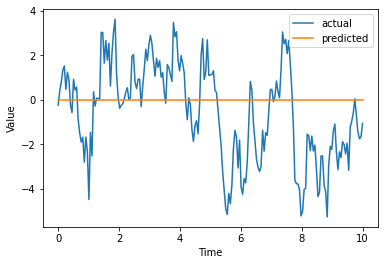

In [32]:
#Plot first 200 data points/predictions for the expanded data
tp = np.linspace(0, 10, 199)
plt.plot(tp, y[:199], label='actual')
plt.plot(tp, yp_pred[:199], label='predicted')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()


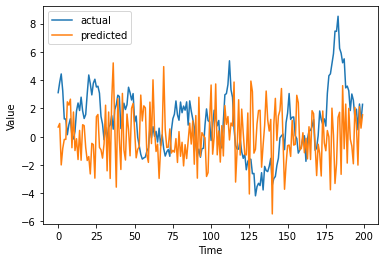

In [33]:
#Plot last 200 data points/predictions for the expanded data

plt.plot(y[-200:], label='actual')
plt.plot(y_pred[-200:], label='predicted')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

In [34]:
#Calculate MSE of predictions for the expanded data

# calculate mean squared error
mse = mean_squared_error(y_test, y_pred)

# print mean squared error
print(f"Mean squared error: ", mse)

Mean squared error:  0.9980124576774201


**Q: How did the model performed when you added the voltage data? How does it compare to the models without it?**

A: The model had reduced mean squared error, which indicates that the model worked much better than before in terms of accuracy. By adding feature such as voltage which is obtained from two other important features in the dataset, we have done feature engineering to improve the performance of the model. In this model, it gets aligned with the true values in the last 200 predictions, in a much better way as compared to the other models.

There are lots of other ways that we could try to improve our model while still using linear regression.

**TODO: Choose one alternative model and re-run the prediction code. Some ideas include:**

- Use a moving average as the response variable
- Make your prediction based on the time of day instead of as a continuous time series
- Use a moving window to limit your predictions instead of using a mu factor

**Q: Describe your alternative model and why it might improve your model**

A: The alternative model that I propose is by increasing the prediction horizon and also reducing the forgotten factor. This will help to increase the model performance as it will be trained with new observations and the weightage of the old observations are reduced. This will help the model to get feedback from its new observations and reduce the overall error in the model. The model will be able to retain the latest observations and make decisions accordingly, which will help to properly align with the trend and ensure much better predictions. The accuarcy of the model will improve as the observations are feeded to the model and it is very much possible to at least get the trend in the future values, if not the accurate values are predicted.

In [40]:
# create your alternative training data here

# define ph and mu
ph = 15
mu = 0.7

# define number of samples and index for ph
n_s = 5000
ph_index = int(ph / 0.1)  # assuming data is sampled every 0.1 seconds

# arrays to hold predicted values
tp_pred = np.zeros(n_s - 1) 
yp_pred = np.zeros(n_s - 1)


In [41]:
#re-run the prediction code here
# create simulated data
ys = np.zeros(n_s)
ys[0] = np.random.normal(0, 1)
for i in range(1, n_s):
    ys[i] = mu * ys[i-1] + np.random.normal(0, 1)

# create predictor variables (time lagged voltage)
X = np.zeros((n_s - ph_index, 2))
X[:, 0] = ys[:-ph_index]
for i in range(ph_index, n_s):
    X[i-ph_index, 1] = ys[i-1]

# create target variable
y = ys[ph_index:]

# split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# train linear regression model
reg = LinearRegression().fit(X_train, y_train)

# make predictions on test set
y_pred = reg.predict(X_test)

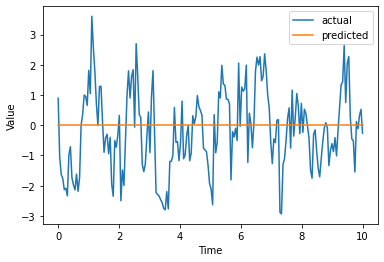

In [42]:
#Plot first 200 data points/predictions for alternative model

tp = np.linspace(0, 10, 200)
plt.plot(tp, y[:200], label='actual')
plt.plot(tp, yp_pred[:200], label='predicted')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

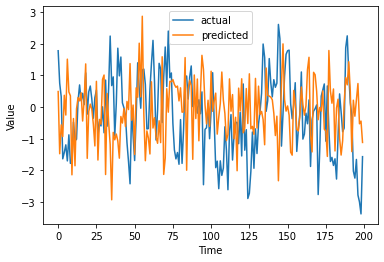

In [43]:
#Plot last 200 data points/predictions for alternative model

plt.plot(y[-200:], label='actual')
plt.plot(y_pred[-200:], label='predicted')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

In [44]:
#Calculate MSE of predictions for alternative model

# calculate mean squared error
mse = mean_squared_error(y_test, y_pred)

# print mean squared error
print(f"Mean squared error: ", mse)

Mean squared error:  0.9672630781065582


**Q: Did your alternative model improve on our previous results? What else could you do to improve the model while still using linear regression?**

A: The alternative model that I created had much better results than only one existing model above. In the model that I built, I increased the value of prediction horizon to 15 and reduced the forgotten factor to 0.7 to generate the output model, which seem to work well over the time. This can be observed from the graphs, where there is alignment in the true and predicted values for the last 200 predictions and less aligned for the first 200 predictions.

Methods to improve the model while using linear regression are:

1. New features can be created from the existing ones or combine them to form more complex features. This can help the model capture more complex relationships between the predictors and the response variable.

2. Outliers can have a significant impact on the model's performance. You can remove outliers from the data or use robust regression techniques that are less sensitive to outliers.

3. We can apply non-linear transformations to the predictors or the response variable to capture non-linear relationships that may exist in the data.

It's worth noting that the results we're getting int his assignment are based on a pretty short predictive horizon of 5 minutes. If we were to increase our predictive horizon, our results would likely be worse and there would be more room for optimizing and improving the predictions of our model.